# Método de análisis basado en técnicas de clustering para la detección de daño estructural

El presente trabajo de investigación forma parte del proyecto de monitorización del estado de salud estructural en puentes.

Los objetivos del método planteado son:
   1. Identificar clusters de las partes del puente que presentan un comportamiento similar, a partir de los datos monitorizados
   2. Complementar las técnicas actuales de detección de daño estructural
   3. Conocer el comportamiento global del puente


In [148]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# librerías genéricas que utilizaremos
from pandas import DataFrame, read_csv
import pylab as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from datetime import datetime
from scipy.fftpack import fft
import scipy.signal.signaltools as sigtool
import sklearn.preprocessing as pre
from sklearn.model_selection import train_test_split

# especificamos variables globales, como por ejemplo el directorio donde tenemos los datos
import glob, os
path = r'./data/71_nodes/' 

# cargamos nuestro métodos
%run outliers_removal.py
%run data_processing.py
%run kmeans.py
%run map_pairwise_distances.py

## Caso de estudio 2: 

- 71 juntas de los segmentos Norte, 6, 7 y 8, monitorizadas durante una semana
- La junta 72 fue reparada recientemente y el sensor de la junta 135 está defectuoso
- Cada evento contiene 100 muestras correspondientes al momento anterior a que pase el vehículo, y se registraron 500 muestras durante y después de que ocurra el evento

In [99]:
# cargamos los datos
all_files = glob.glob(os.path.join(path, "data_71nodes_chunk*.csv"))
df_from_each_file = (pd.read_csv(f, index_col=0) for f in all_files)
datav1 = pd.concat(df_from_each_file)
joints = read_csv(path+"joints_71nodes.csv", header=None)
joints = joints[~np.isnan(datav1).any(axis=1)]
datav1 = datav1[~np.isnan(datav1).any(axis=1)]
print ('Dimensiones de los datos de entrada: ' + str(datav1.shape))

Dimensiones de los datos de entrada: (45819, 500)


## Un primer vistazo a los datos

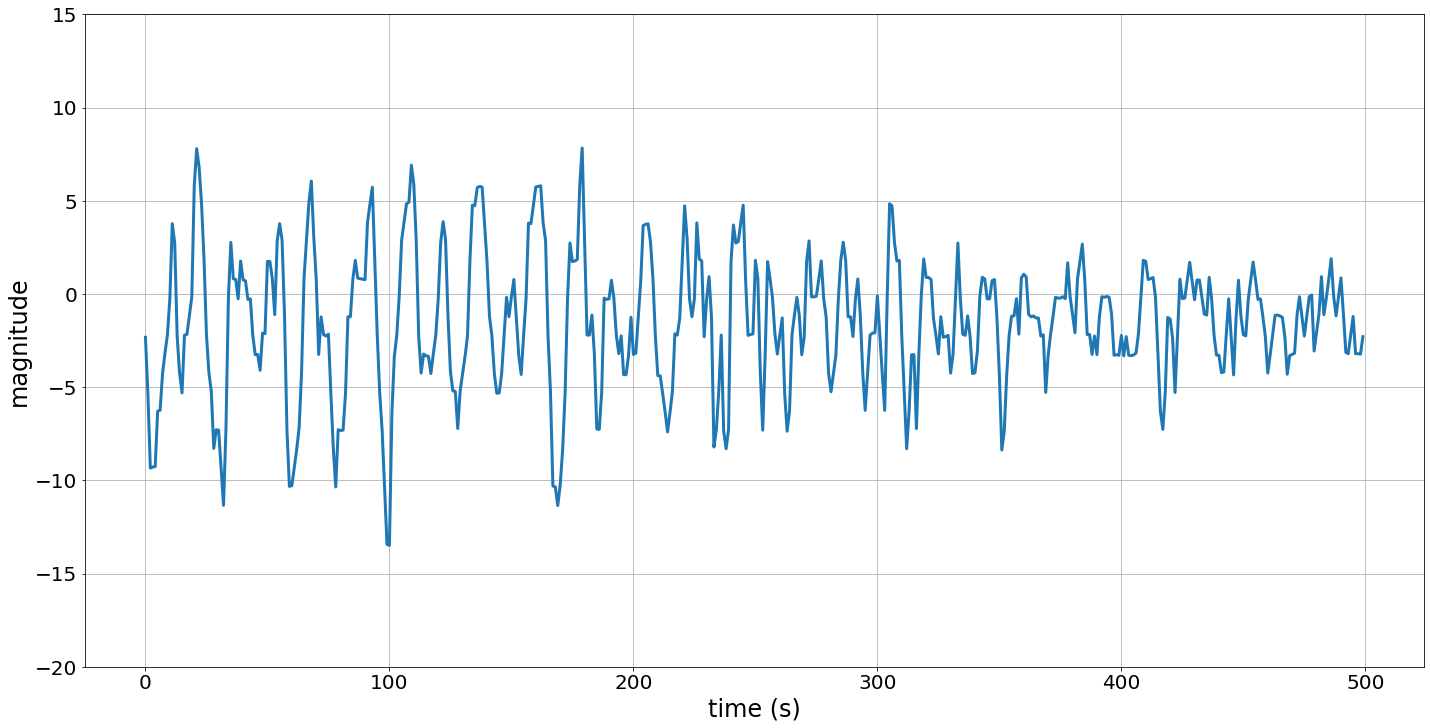

In [82]:
# graficamos un vector de características
plt.figure(figsize=(24, 12))
plt.plot(datav1.values[100], lw=3)
plt.xlabel('time (s)', fontsize=24)
plt.ylabel('magnitude', fontsize=24)
plt.tick_params(labelsize=20)
plt.ylim(-20,15)
plt.grid()
plt.show()

## Preprocesado

In [100]:
# estandarización de los datos
from numpy import mean, std
datav1 = (datav1.values - mean(datav1.values, axis=0)) / std(datav1.values, axis=0)

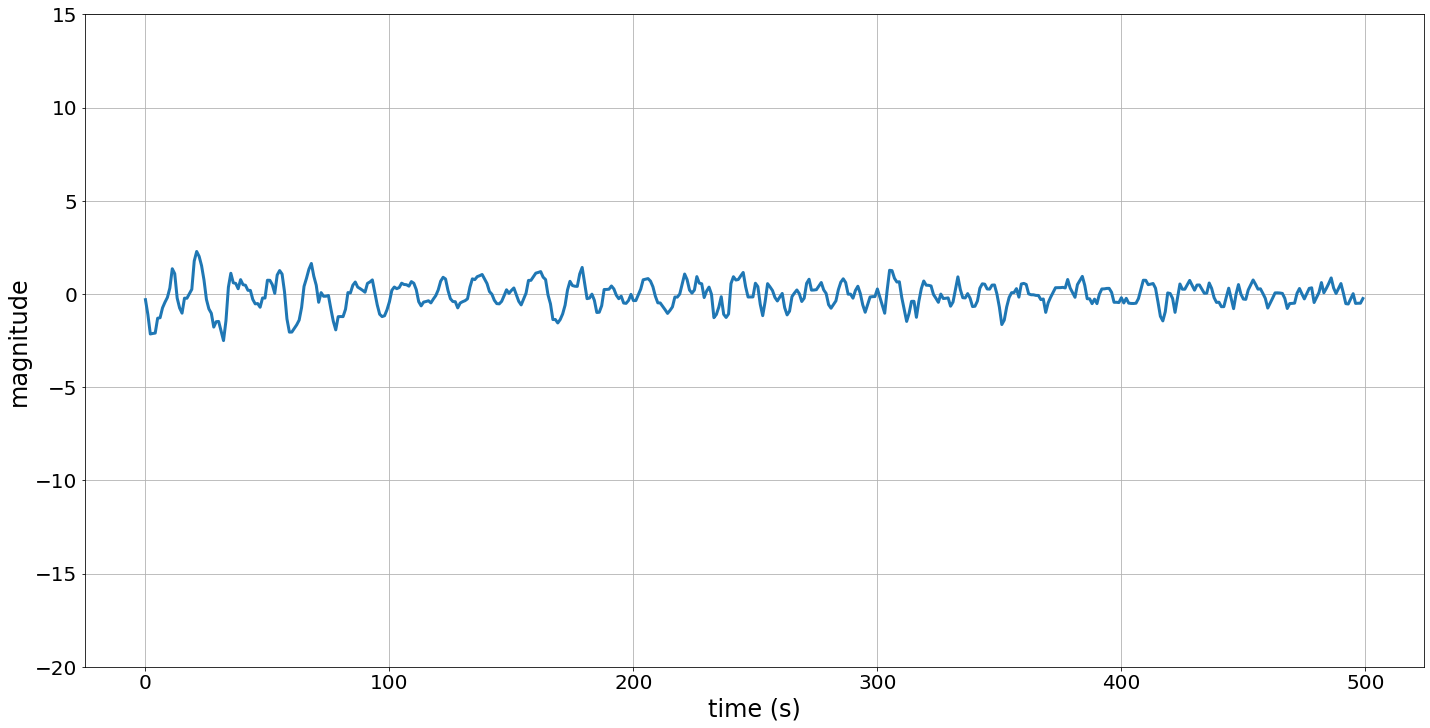

In [84]:
# mostramos un vector de características tras estandarizar los datos originales
plt.figure(figsize=(24, 12))
plt.plot(datav1[100], lw=3)
plt.xlabel('time (s)', fontsize=24)
plt.ylabel('magnitude', fontsize=24)
plt.tick_params(labelsize=20)
plt.ylim(-20,15)
plt.grid()
plt.show() 

## Información contextual: posición y distribución de las juntas del puente

In [101]:
joints=np.array(joints)
joints=joints.reshape(joints.shape[0])
joints_dist = [[17,24,25,26,21,22],[13,20,16,14,15,11],[18,12,19,27,28,29],[30,31,33,34,35],[37,39,41],[42,43,45,47],[143,142,141,140,139,138],[136,135,134,133,131],[129,128,126,125],[123,121],[111,110,109,107],[177,175],[174,173,172,169],[165,164],[162,161,160,159],[82],[78,77,75,74,73,72],[99]]

## Eliminar outliers y ruido de los datos

In [102]:
'''
Método que elimina outliers para limpiar y hacer un remuestreo de los datos, de tal modo que para cada junta eliminamos los eventos cuya energía está lejos de la media. 
    Entradas:
        - data: conjunto de datos de entrenamiento, con los eventos que vamos a procesar (matrix [m,n])
        - index: la lista de juntas a las que pertenece cada evento (array [m])
        - k: número de vecinos a considerar por el KDTree y máximo número de eventos a obtener por junta
        - normalityLoops: criterio de parada principal
        - anomaly_threshold: desviaciones típicas respecto de la media a utilizar
    Salidas: (reduced_data, reduced_index, samples_distribution) objetos que contienen los datos procesados, las etiquetas (juntas) correspondientes y la distribución final de juntas resultantes 
'''
# el número de vecinos, 'k', se especifica en función de la cantidad de eventos por junta del puente
# 'normalityLoops' se especifica a 1 para no eliminar demasiada información
reduced_data, reduced_index, samples_distribution, removed_data, removed_index = outliers_removal(datav1, 
                                                                                                  joints, 
                                                                                                  k=500, 
                                                                                                  normalityLoops=1,
                                                                                                  anomaly_threshold=2)
# mostramos el número de muestras resultantes
print ('Dimensiones de los datos procesados: ' + str(reduced_data.shape))


Joint 11
Iteration 1
462
Average distance: 108.311890
Max distance: 843.140345
Setting threshold to  155.408542
Number of samples removed: 19
Number of iterations reached. Exiting

Joint 12
Iteration 1
500
Average distance: 28.640234
Max distance: 58.965785
Setting threshold to  36.831198
Number of samples removed: 1088
Number of iterations reached. Exiting

Joint 13
Iteration 1
500
Average distance: 122.471731
Max distance: 341.240273
Setting threshold to  164.912087
Number of samples removed: 39
Number of iterations reached. Exiting

Joint 14
Iteration 1
500
Average distance: 183.759293
Max distance: 465.513538
Setting threshold to  242.791176
Number of samples removed: 49
Number of iterations reached. Exiting

Joint 15
Iteration 1
500
Average distance: 118.707581
Max distance: 347.362509
Setting threshold to  159.237872
Number of samples removed: 39
Number of iterations reached. Exiting

Joint 16
Iteration 1
500
Average distance: 214.887102
Max distance: 578.134854
Setting threshol

Average distance: 196.357582
Max distance: 497.598372
Setting threshold to  255.259409
Number of samples removed: 50
Number of iterations reached. Exiting

Joint 129
Iteration 1
500
Average distance: 162.694085
Max distance: 406.126170
Setting threshold to  215.354615
Number of samples removed: 41
Number of iterations reached. Exiting

Joint 131
Iteration 1
500
Average distance: 124.595399
Max distance: 295.494292
Setting threshold to  156.913930
Number of samples removed: 59
Number of iterations reached. Exiting

Joint 133
Iteration 1
500
Average distance: 144.801179
Max distance: 401.283780
Setting threshold to  192.165091
Number of samples removed: 52
Number of iterations reached. Exiting

Joint 134
Iteration 1
500
Average distance: 149.195197
Max distance: 419.681569
Setting threshold to  198.354131
Number of samples removed: 52
Number of iterations reached. Exiting

Joint 135
Iteration 1
500
Average distance: 176.705093
Max distance: 356.347338
Setting threshold to  227.321690
Num

## Transformada de Fourier (FFT): del dominio temporal al dominio en frecuencias

In [103]:
# aplicamos FFT a los datos estandarizados
reduced_data_fft = np.fft.rfft(reduced_data)
reduced_data_fft = np.abs(reduced_data_fft)

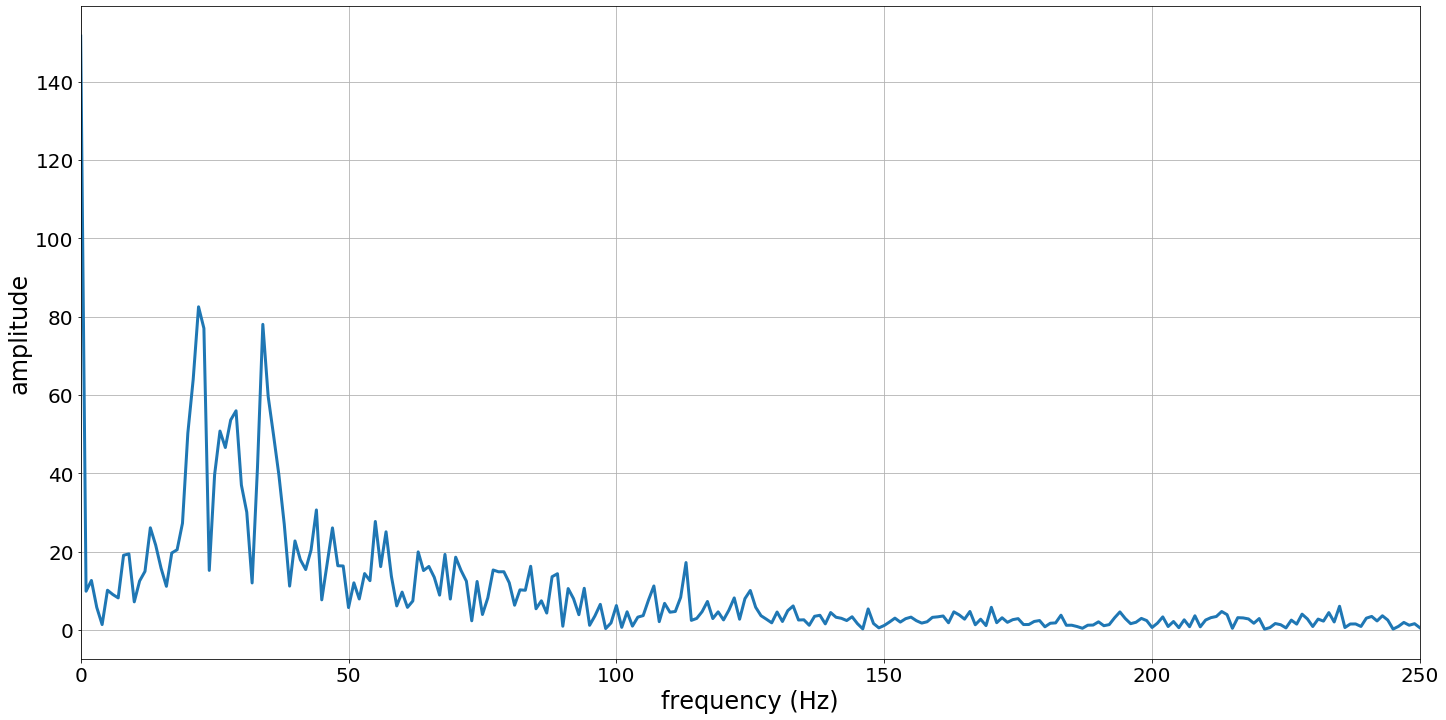

In [104]:
# mostramos una señal en frecuencias resultante
plt.figure(figsize=(24, 12))
plt.plot(reduced_data_fft[100], lw=3)
plt.xlabel('frequency (Hz)', fontsize=24)
plt.ylabel('amplitude', fontsize=24)
plt.tick_params(labelsize=20)
plt.xlim(0,250)
plt.grid()
plt.show()

## Clustering basado en eventos: K-medias (distancia Euclídea)

In [115]:
from sklearn.cluster import KMeans
'''
Método K-medias basado en la implementación de sklearn.
    Entradas:
        - data: conjunto de datos de entrenamiento, con los eventos que vamos a procesar (matrix [m,n])
        - n_clusters: número de clusters a utilizar
    Outputs: (Z, centroids, kmeans) array que contiene el cluster al que pertenece cada evento (array [m]), centroides o valores medios (matrix [m, n_clusters]) y el modelo kmeans resultante
'''
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=20)
kmeans.fit(reduced_data_fft)
Z = kmeans.labels_ 

In [116]:
# obtenemos los centroides   
centroids = kmeans.cluster_centers_
inertia = kmeans.inertia_      
print('Sum of distances of events to their closest cluster center: ' + str(inertia))
final_u = Z 
final_centroids = centroids
final_dist = kmeans

Sum of distances of events to their closest cluster center: 1064712612.7400889


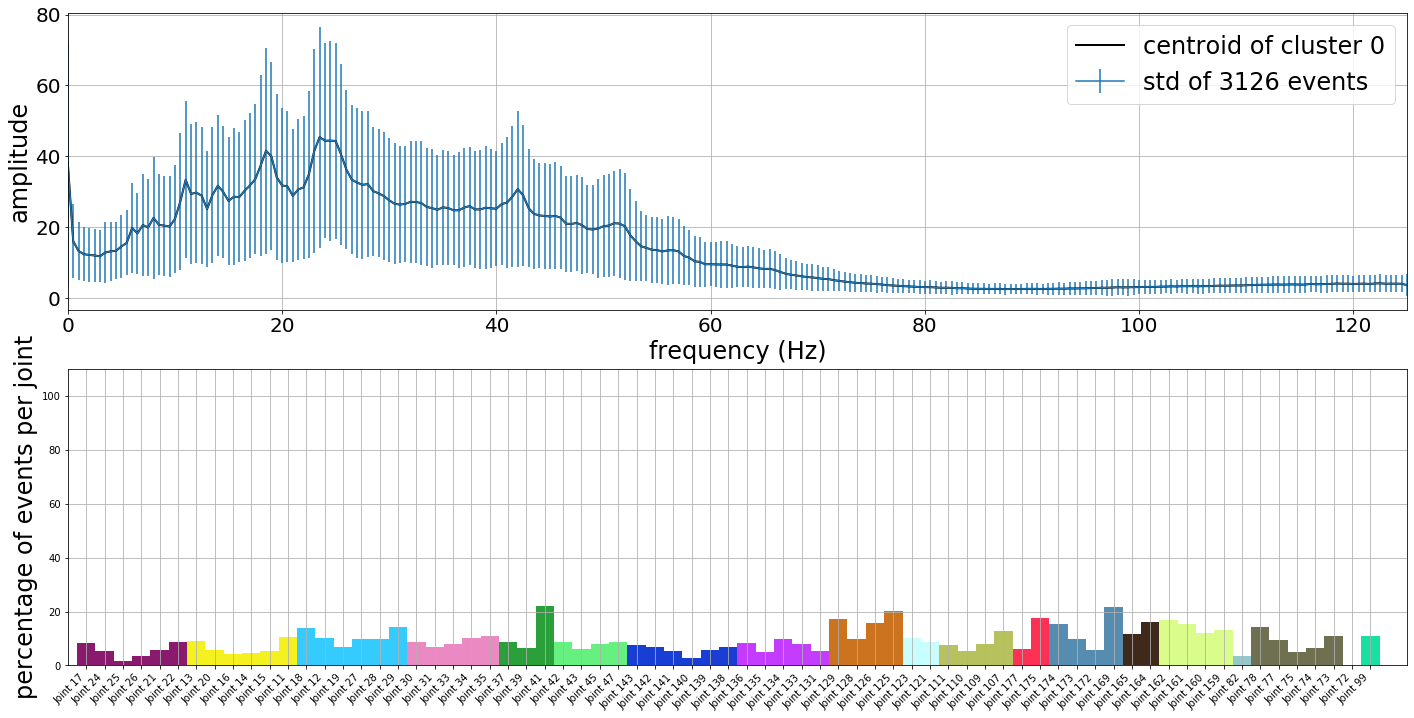

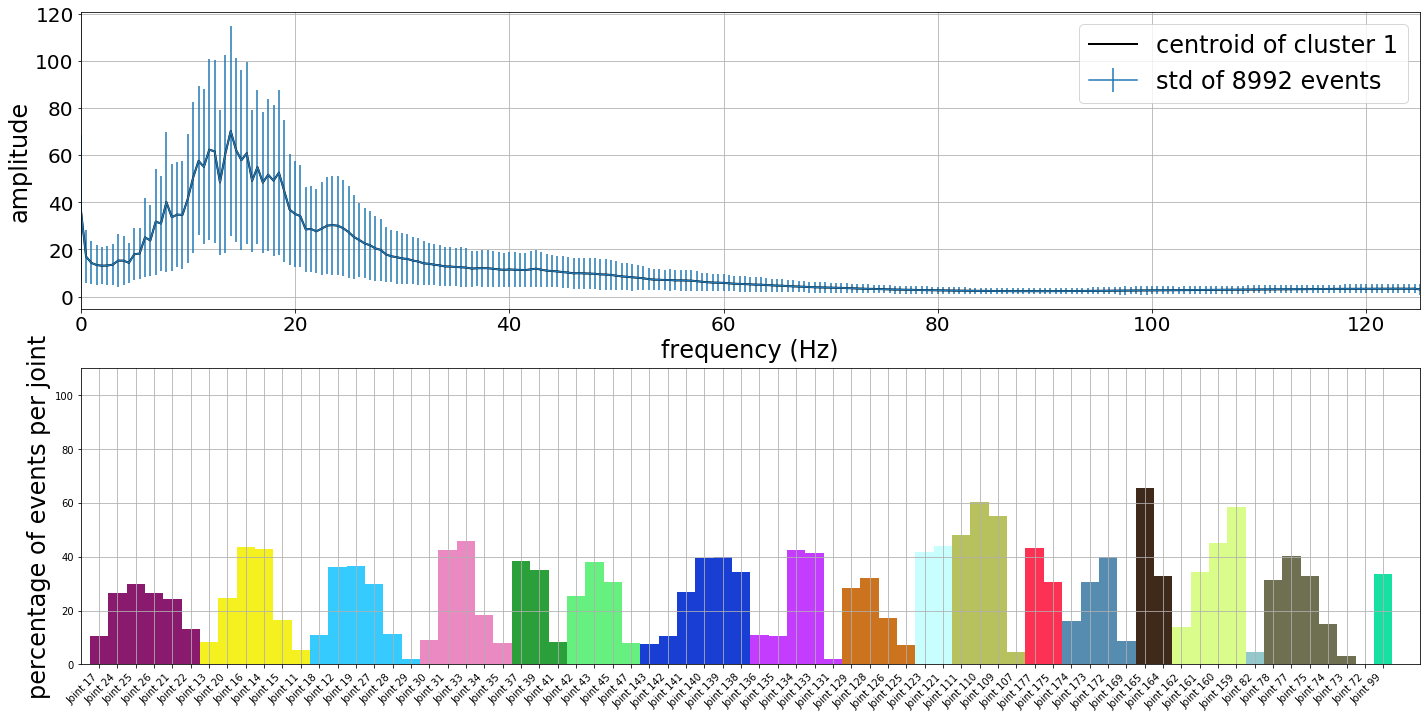

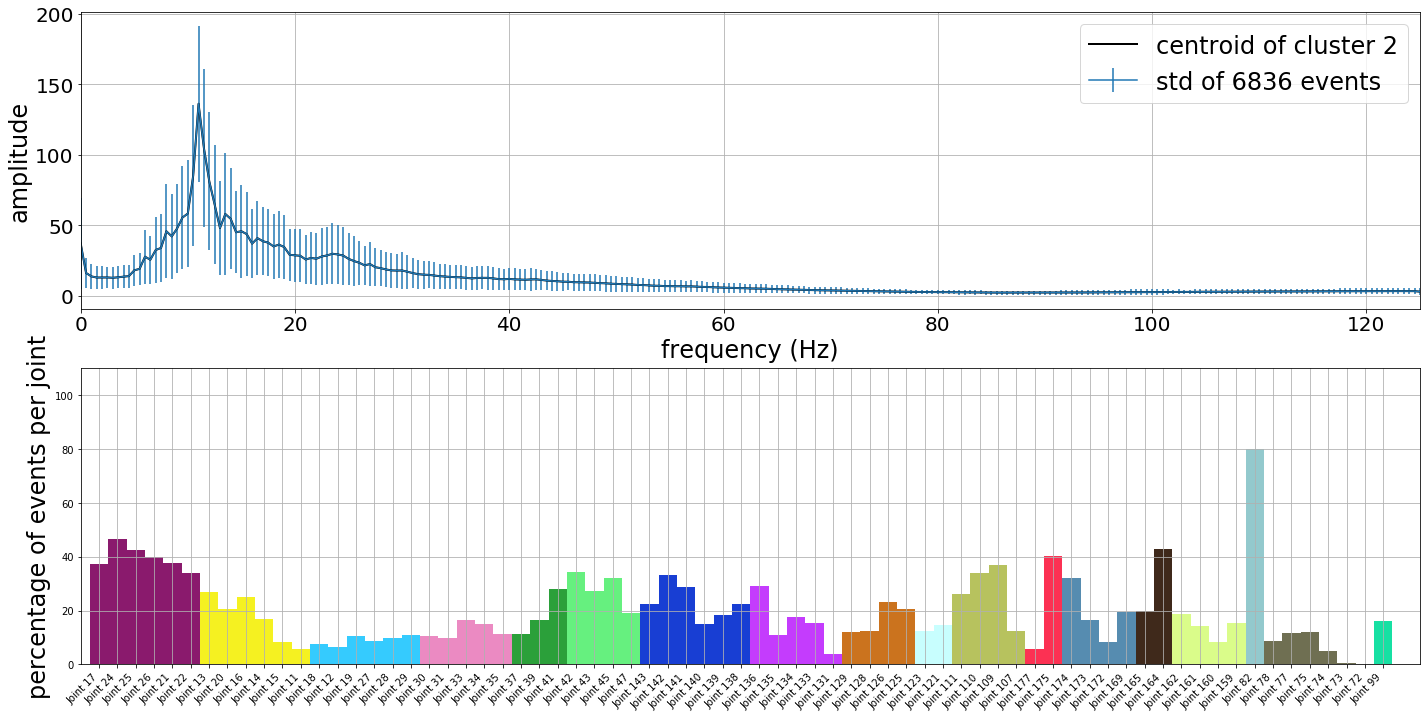

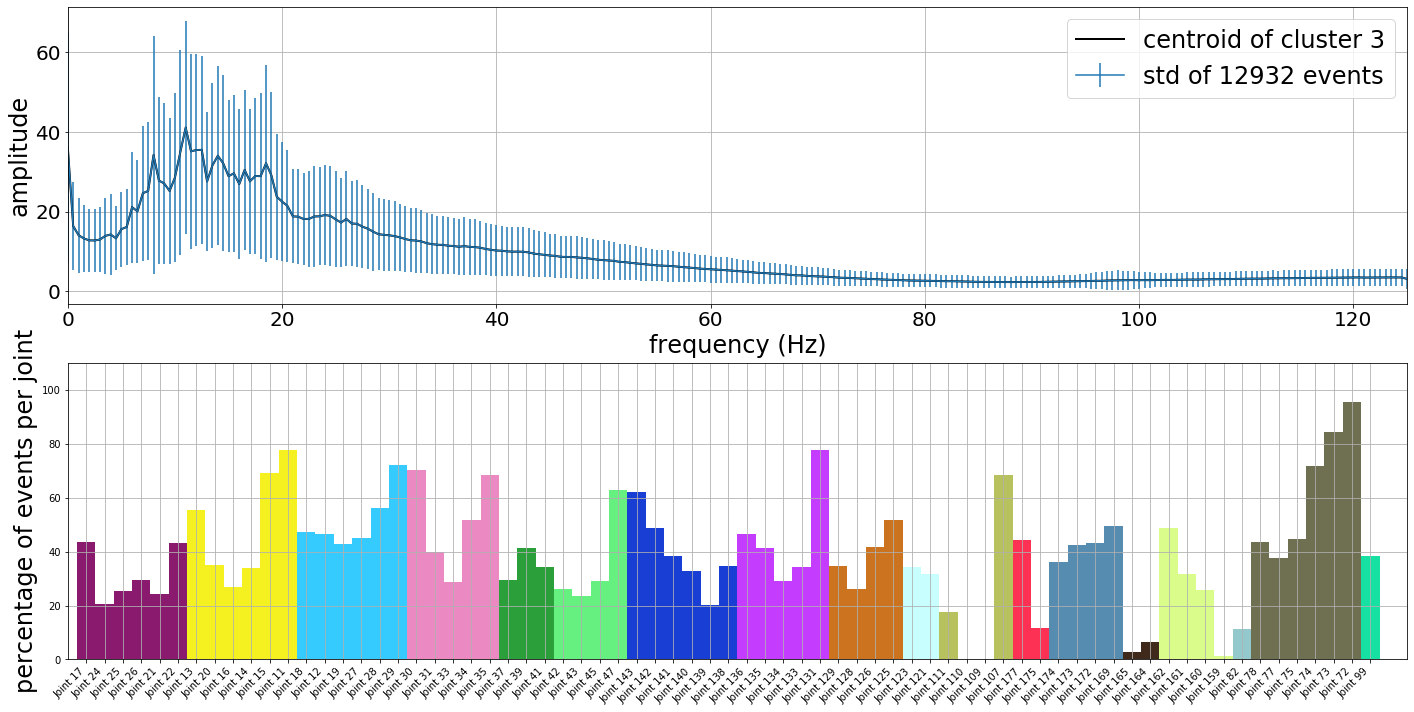

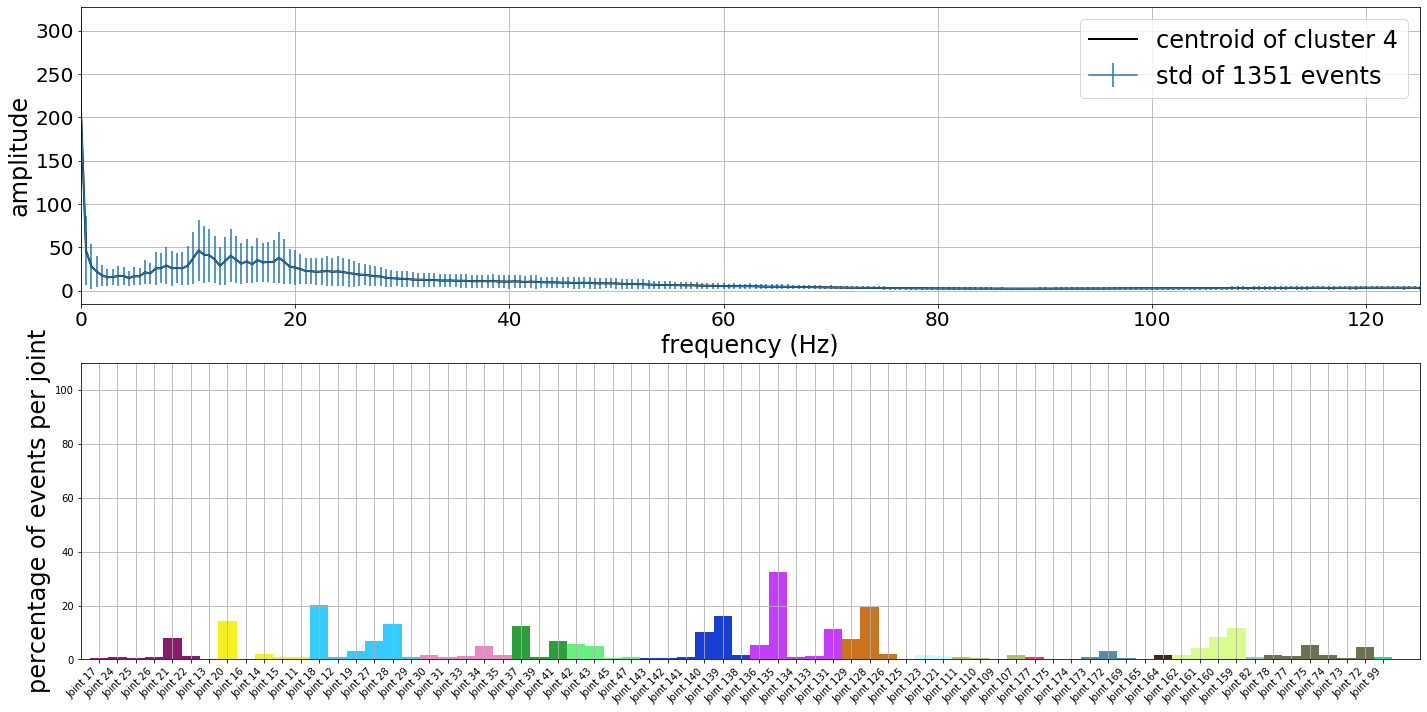

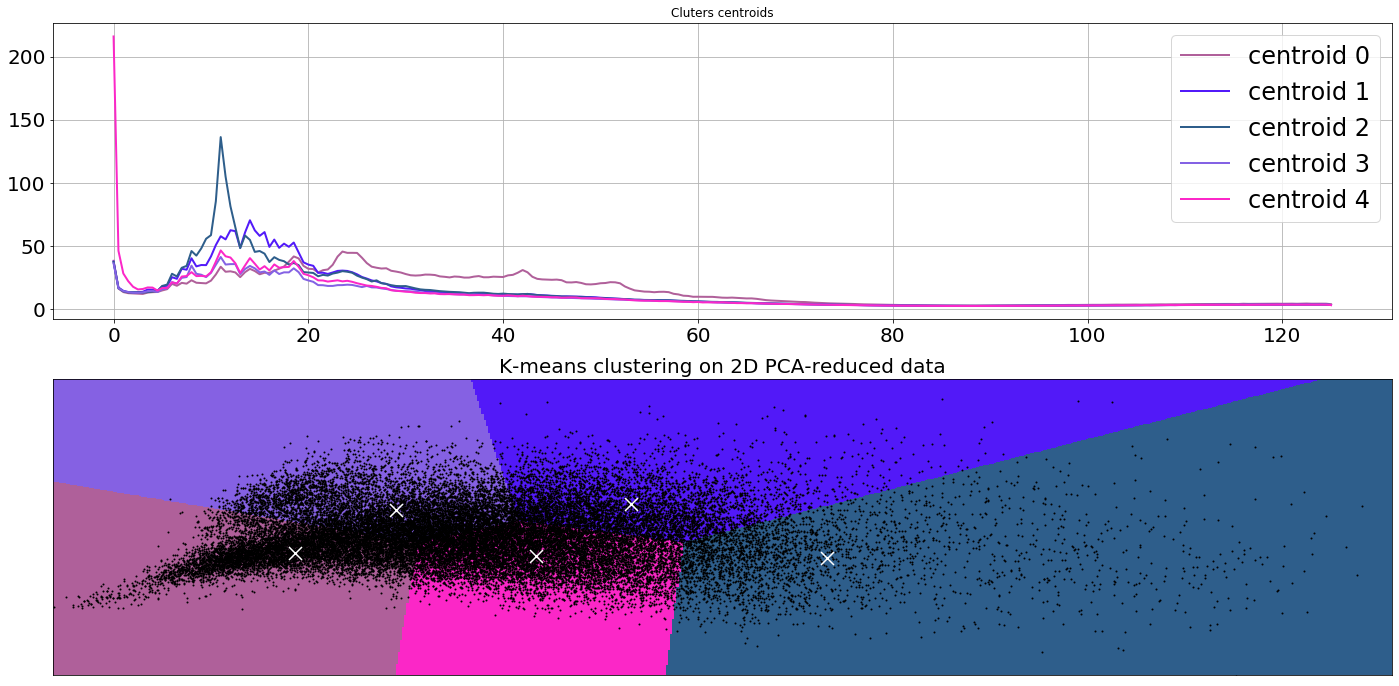

In [133]:
'''
Método que muestra los resultados del clustering.
    Entradas:
        - data: conjunto de datos con los eventos que vamos a procesar (matrix [m,n])
        - index: la lista de juntas a las que pertenece cada evento (array [m])
        - samples_distribution: distribución de las juntas, una fila por cada set de jutas que pertenecen a una misma zona del puente y que tendrán el mismo color en el grafo
        - centroids: centroides o valores medios (matrix [m, n_clusters])
        - Z: array que contiene el cluster al que pertenece cada evento (array [m])
        - njoints: 6 o 71, en base al caso de estudio planteado
    Salidas: cada cluster se representa mediante 2 grafos, el de la parte superior muestra el centroide y la desviación típica de los eventos agrupados en el cluster y en la parte inferior se muestra la distribución de los eventos
'''
draw_clustering_results(reduced_data_fft,reduced_index,joints_dist,final_centroids,final_u,njoints=71)

## Clustering basado en juntas: mapa de distancias entre los representantes de las juntas

In [142]:
'''
Método que calcula la media de los eventos correspondientes a cada junta (señales representativas de cada junta).
    Entradas:
        - data: conjunto de datos de entrenamiento, con los eventos que vamos a procesar (matrix [m,n])
        - labels: la lista de juntas a las que pertenece cada evento (array [m])
        - samples_distribution: distribución de las juntas, una fila por cada set de jutas que pertenecen a una misma zona del puente y que tendrán el mismo color en el grafo
    Salidas: (means, joints) las señales representativas de cada junta, o valores medios (matrix [j,n], j=número de juntas diferentes) y joints la lista con las etiquetas de las juntas (array [j])
'''     
means, joints = calculate_joints_means(reduced_data_fft, reduced_index, joints_dist)

array([[  0.        ,  80.16008376,  98.92148235, ..., 108.71033414,
        142.84591306,  81.01205468],
       [ 80.16008376,   0.        ,  38.27046363, ..., 163.74693053,
        201.80541434, 116.26453691],
       [ 98.92148235,  38.27046363,   0.        , ..., 170.8797984 ,
        205.326246  , 131.83380971],
       ...,
       [108.71033414, 163.74693053, 170.8797984 , ...,   0.        ,
         54.86346982, 105.55459473],
       [142.84591306, 201.80541434, 205.326246  , ...,  54.86346982,
          0.        , 144.4780037 ],
       [ 81.01205468, 116.26453691, 131.83380971, ..., 105.55459473,
        144.4780037 ,   0.        ]])

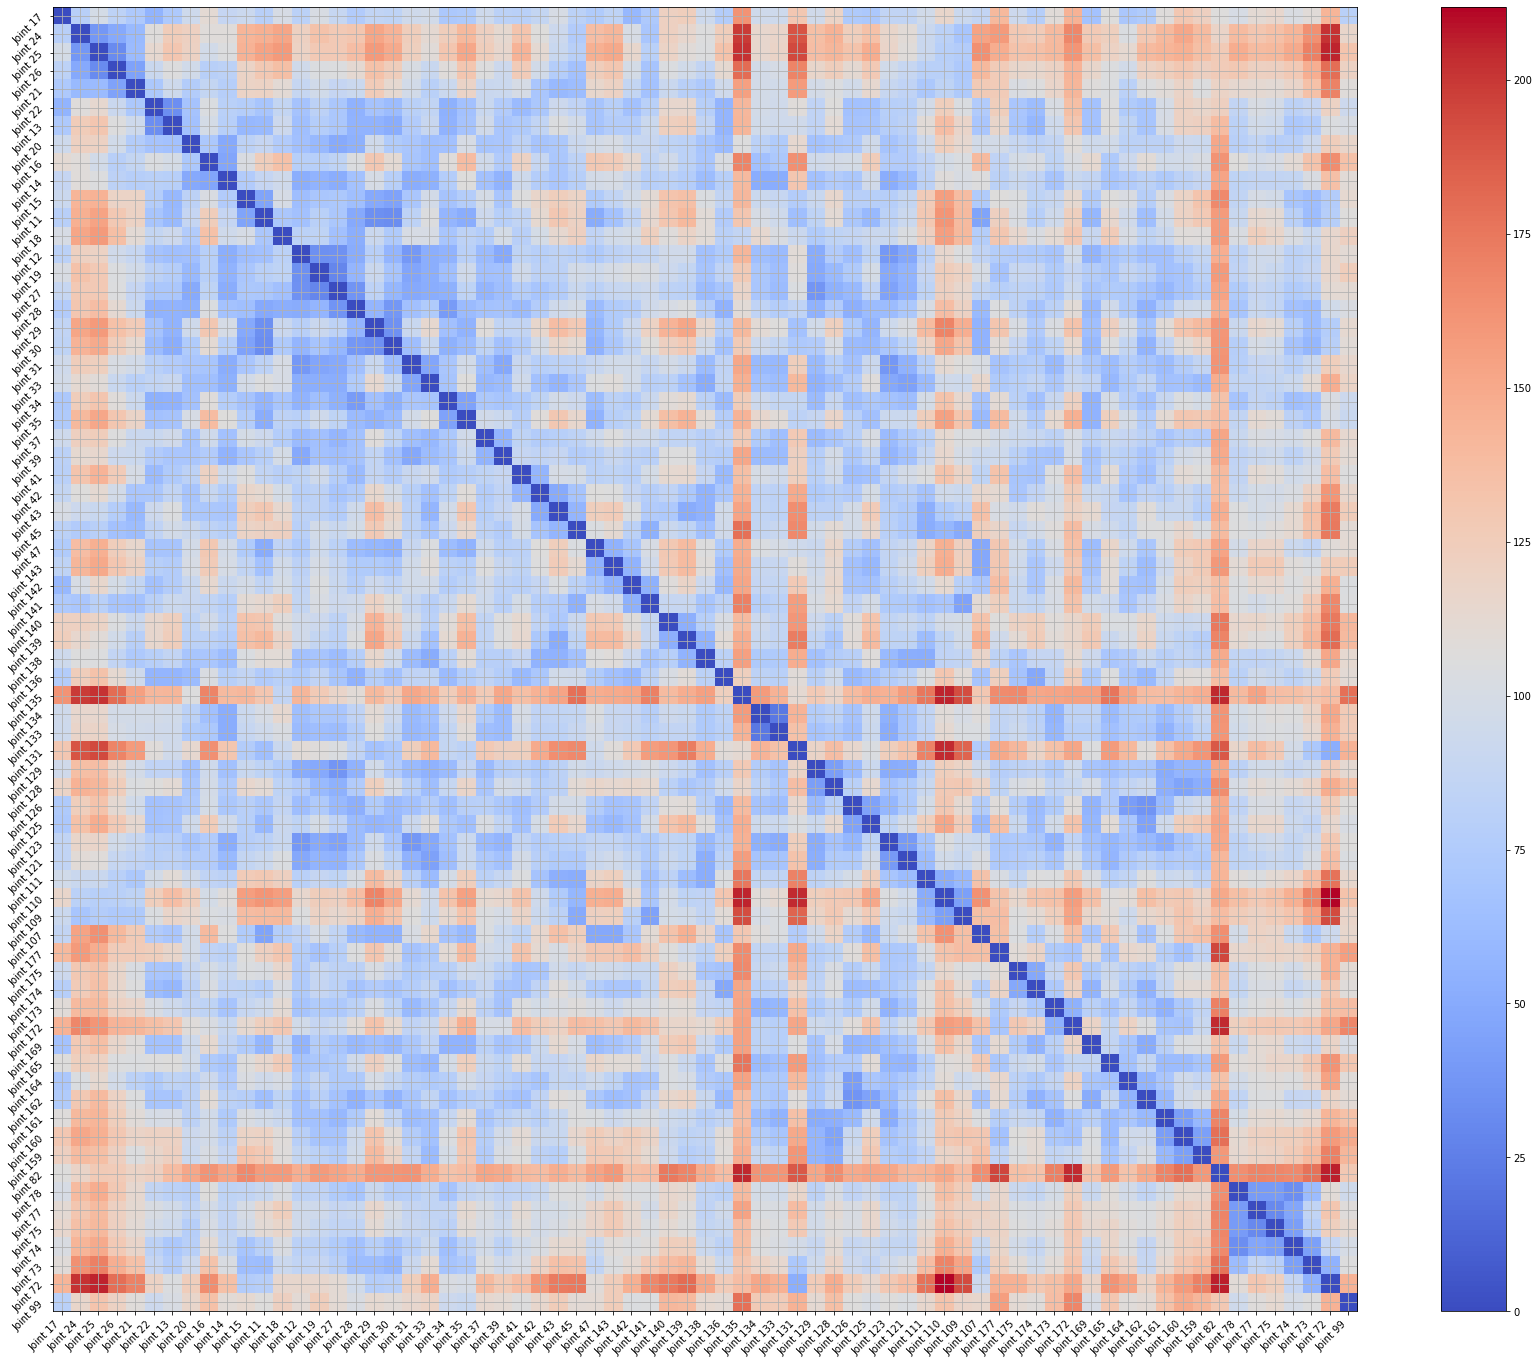

In [149]:
'''
Método que crea un mapa o matriz de distancias.
    Entradas:
        - centroids: los representates de las juntas (matrix [j,n])            
        - labels: las etiquetas de las juntas (array [j])        
        - weights: pesos de los centroides (array [m]) 
        - distance: métrica de distancia a aplicar: Euclidean, Manhattan, Correlation, Minkowski, Minkowski_pthPower, Chebyshev
        - p: pthPower utilizado en la distancia de Minkowski
    Salidas: (global_matrix) el mapa o matriz de distancias resultante (matrix [m,m])
'''
draw_matrix_of_distances(means, joints, njoints=71, weights=None, distance='Euclidean', p=0.1)

## Conclusiones

- Los resultados experimentales demuestran que el método propuesto es capaz de detectar daño estructural y anomalías en los datos de manera precisa
- Las similitudes encontradas en las juntas de las zonas centrales de los segmentos del puente en el caso de estudio 2, proporcionan un sistema de clasificación basado en la posición robusto y fiable. Además, se detectó un sensor defectuoso en una de las juntas y una junta que se había reparado recientemente, y por tanto mostraba un comportamiento ligeramente diferente al resto  
- El método propuesto se aplica en tiempo real para establecer el estado de salud de la estructura, en base a las distancias a los modelos obtenidos, y así poder tomar decisiones de negocio que aseguren el tráfico rodado seguro y un servicio eficiente y fiable